In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import re

In [37]:
from nltk import FreqDist
from konlpy.tag import Kkma, Okt

kkma = Okt()
kkma.nouns("KAL사거리")

['사거리']

In [38]:
# NOTE: Custome Module !!
from module.dataframe import df_query_by_type, series_string_filter

In [39]:
train = pd.read_parquet("./database/train.parquet")
test = pd.read_parquet("./database/test.parquet")

### Check Data
---

In [40]:
# NOTE: Check DataType
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [41]:
# NOTE: Check Statistics int type
train.drop(columns=["base_date", "base_hour"]).describe(include=[int])

,lane_count,road_rating,multi_linked,connect_code,road_type
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.152237e-01
std,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.211268e+00
min,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,0.000000e+00
max,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,3.000000e+00


In [42]:
# NOTE: Check Statistics float type
# 좌표값을 의미하는 latitude, longitude는 제외
train.drop(columns=["start_latitude", "start_longitude", "end_latitude", "end_longitude"]).describe(
    include=[float]
)

,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,target
count,4.701217e+06,4701217.0,4.701217e+06,4701217.0,4.701217e+06
mean,6.125329e+01,0.0,5.618742e+03,0.0,4.278844e+01
std,1.213354e+01,0.0,1.395343e+04,0.0,1.595443e+01
min,3.000000e+01,0.0,0.000000e+00,0.0,1.000000e+00
25%,5.000000e+01,0.0,0.000000e+00,0.0,3.000000e+01
50%,6.000000e+01,0.0,0.000000e+00,0.0,4.300000e+01
75%,7.000000e+01,0.0,0.000000e+00,0.0,5.400000e+01
max,8.000000e+01,0.0,5.000000e+04,0.0,1.130000e+02


In [43]:
# NOTE: 각 Column별로 결측 값이 있는지 확인.
is_nullable = train.isnull().sum(axis=0)
is_nullable[is_nullable != 0].index

Index([], dtype='object')

In [44]:
# NOTE: 각 Column별로 구분되는 값이 얼마나 있는지 확인하기.
# 1이 있으면 모든 Column의 값들이 동일 하다는 것을 의미.
is_unique = train.apply(pd.Series.unique, axis=0).apply(len)
is_unique[is_unique == len(train)].index, is_unique[is_unique == 1].index

(Index(['id'], dtype='object'),
 Index(['vehicle_restricted', 'height_restricted'], dtype='object'))

### Visualize
---

<Axes: xlabel='target', ylabel='Frequency'>

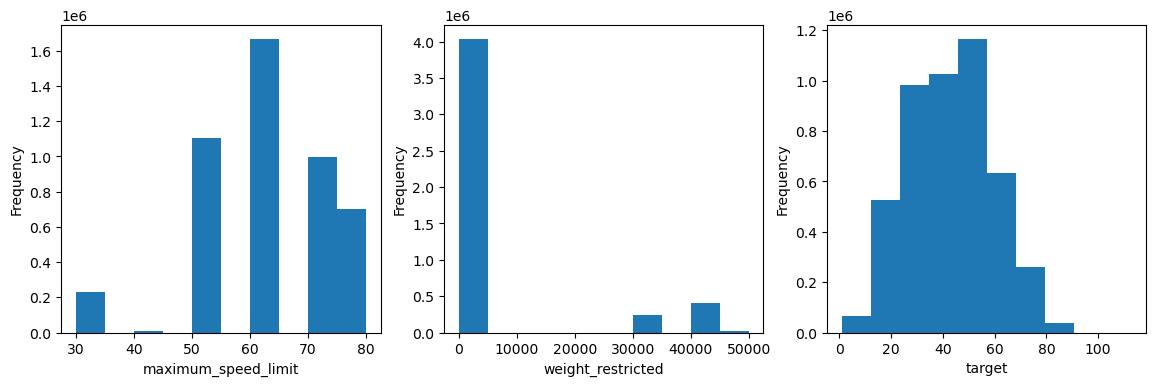

In [45]:
plt.rcParams["figure.figsize"] = (14, 4)
fig1, axes1 = plt.subplots(1, 3)
df_query_by_type(train, float)["maximum_speed_limit"].plot.hist(ax=axes1[0], xlabel="maximum_speed_limit")
df_query_by_type(train, float)["weight_restricted"].plot.hist(ax=axes1[1], xlabel="weight_restricted")
df_query_by_type(train, float)["target"].plot.hist(ax=axes1[2], xlabel="target")

<Axes: xlabel='road_type', ylabel='Frequency'>

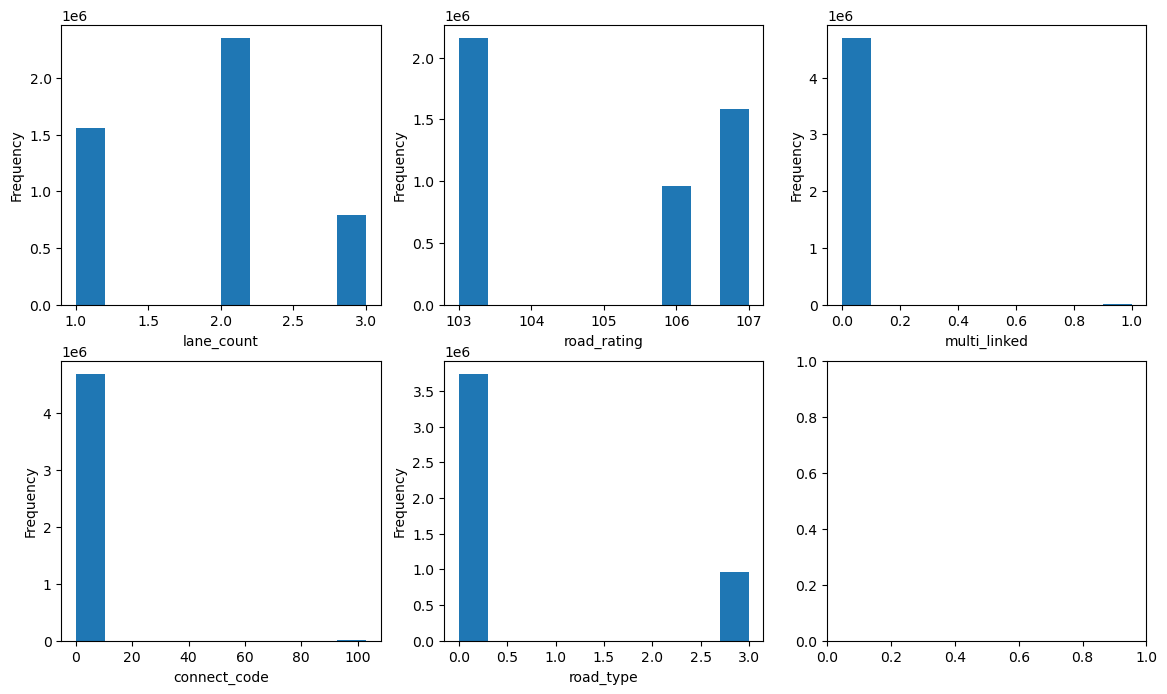

In [46]:
plt.rcParams["figure.figsize"] = (14, 8)
fig2, axes2 = plt.subplots(2, 3)
df_query_by_type(train, int)["lane_count"].plot.hist(ax=axes2[0, 0], xlabel="lane_count")
df_query_by_type(train, int)["road_rating"].plot.hist(ax=axes2[0, 1], xlabel="road_rating")
df_query_by_type(train, int)["multi_linked"].plot.hist(ax=axes2[0, 2], xlabel="multi_linked")
df_query_by_type(train, int)["connect_code"].plot.hist(ax=axes2[1, 0], xlabel="connect_code")
df_query_by_type(train, int)["road_type"].plot.hist(ax=axes2[1, 1], xlabel="road_type")

### Check "road_name"

---

In [47]:
# NOTE: 자주나는 표현 확인하기
df = df_query_by_type(train, object)
column_name = ["road_name", "start_node_name", "end_node_name"]

freq_dist = {col_name: None for col_name in column_name}
for col_name in column_name:
    _text = " ".join(df[col_name].to_list())
    _text = re.sub("[^-가-힣\s]", "", _text).split(" ")
    freq_dist[col_name] = FreqDist(_text)

In [51]:
print(freq_dist["road_name"].keys())

tourism_road = ["관광단지", "관광도로"]
general_road = ["지방도", "일반국도", "길", "로"]
bridge_road = ["교", "천교"]
nontaged_road = ["-"]
road_type = tourism_road + general_road + bridge_road + nontaged_road

print(
    "모든 카테고리를 설명할 수 있나요?:",
    (len(df) - len(df[series_string_filter(df["road_name"], road_type)])) == 0,
)

dict_keys(['지방도호선', '일반국도호선', '태평로', '경찰로', '-', '외도천교', '중정로', '번영로', '연동로', '중산간서로', '새서귀로', '어시천교', '삼무로', '애조로', '동부관광도로', '동홍로', '중문로', '연삼로', '중앙로', '산서로', '연북로', '남조로', '동문로', '한천로', '삼봉로', '고평교', '연북교', '관광단지로', '권학로', '시청로', '신대로', '서사로', '관덕로', '신산로', '신광로', '첨단로', '제거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로', '아봉로', '호근로'])
모든 카테고리를 설명할 수 있나요?: True
